In [1]:
DATASET_NAME = "Deco"

DATA_DIR = "data"
REFINED_PATH = f"../output/{DATASET_NAME}/refined.json"
PAPER_RESULTS = f"../output/{DATASET_NAME}/NoTrainingNoSeed"
OWN_RESULTS = f"../swap/"
from os import listdir
from os.path import join, isdir

EXPERIMENTS = [d for d in listdir(OWN_RESULTS) if isdir(join(OWN_RESULTS, d))]


# EXPERIMENTS = ["own_data_over_header_2"]
# OWN_RESULTS = "../output"

In [2]:
import json
from os.path import join

from experiments.Analyser import *
from labelregions.BoundingBox import BoundingBox

with open(REFINED_PATH) as f:
    refined = json.load(f)


def paper_results(key):
    with open(join(PAPER_RESULTS, f"{key}_result.json")) as f:
        data = json.load(f)
    return result_eval(key, data)


def experiment_path(experiment_name):
    return join(OWN_RESULTS, experiment_name, DATASET_NAME, "OWN_NoTrainingNoSeed")

def own_results(key, experiment_name):
    with open(join(experiment_path(experiment_name), f"{key}_result.json")) as f:
        data = json.load(f)
    return result_eval(key, data)
    
    
def result_eval(key, data):
    ground_truth = [BoundingBox(r["top"], r["left"], r["bottom"], r["right"]) for r in data["ground_truth"]]
    detected = [BoundingBox(r["top"], r["left"], r["bottom"], r["right"]) for r in data["detected"]]
    
    
    results = {
        **bayesian_scores(ground_truth, detected),
        **detection_evaluation(ground_truth, detected),
        "accuracy": accuracy_based_on_jacard_index(ground_truth, detected)
    }
    return results

In [3]:
experiment_results = {}

for experiment_name in EXPERIMENTS:
    file_diffs = {}
    metric_diffs = {}

    for file in refined.keys():
        if refined[file]["edge_count"] <= 10:
            continue
        own = own_results(file, experiment_name)
        paper = paper_results(file)

        diffs = {}
        for key in own.keys():
            diff = own[key] - paper[key]

            diffs[key] = diff
            metric_diffs[key] = metric_diffs.get(key, []) + [diff]
        file_diffs[file] = diffs

    experiment_results[experiment_name] = {"file_diffs": file_diffs, "metric_diffs": metric_diffs}

In [4]:
multi_table_files = {}
single_table_files = {}
all_files = {}

for experiment_name, data in experiment_results.items():
    multi_table_files[experiment_name] = []
    single_table_files[experiment_name] = []
    all_files[experiment_name] = []
    
    file_diffs = data["file_diffs"]
    for key, value in file_diffs.items():
        if refined[key]["table_count"] > 1:
            multi_table_files[experiment_name].append(value)
        else:
            single_table_files[experiment_name].append(value)
        all_files[experiment_name].append(value)
            

In [5]:
from statistics import mean, stdev

for experiment_name in EXPERIMENTS:
    multi_table_results = multi_table_files[experiment_name]
    single_table_results = single_table_files[experiment_name]
    all_results = all_files[experiment_name]
    
    multi_table_accuracy = [v["accuracy"] for v in multi_table_results]
    single_table_accuracy = [v["accuracy"] for v in single_table_results]
    all_accuracy = [v["accuracy"] for v in all_results]
    
    print("\n".join([
        f"{experiment_name} accuracy",
        f"\tMulti: {mean(multi_table_accuracy)}, {stdev(multi_table_accuracy)}",
        f"\tSingle: {mean(single_table_accuracy)}, {stdev(single_table_accuracy)}",
        f"\tAll: {mean(all_accuracy)}, {stdev(all_accuracy)}",
    ]))

own_same_over_different accuracy
	Multi: 0.03302826285153236, 0.2906241930875952
	Single: 0.02066115702479339, 0.42189404096818534
	All: 0.024199827423594805, 0.3885021965096073
own_data_over_header accuracy
	Multi: 0.042345769923089506, 0.3356495097912809
	Single: 0.024793388429752067, 0.39630680761908993
	All: 0.029815751275928268, 0.37953564749736624
own_horizontal_over_vertical_alignment accuracy
	Multi: 0.05354791401096521, 0.33132037151837723
	Single: 0.012396694214876033, 0.4122743814890515
	All: 0.0241715270178868, 0.3907900388715444


own_data_over_header accuracy
	Multi: 0.042345769923089506, 0.3356495097912809
	Single: 0.024793388429752067, 0.39630680761908993
	All: 0.029815751275928268, 0.37953564749736624


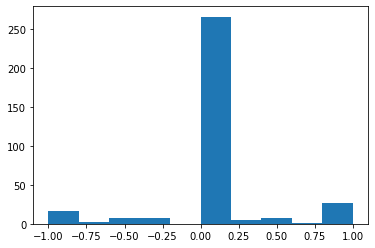

In [6]:
import matplotlib.pyplot as plt


for experiment_name in ["own_data_over_header"]:
    multi_table_results = multi_table_files[experiment_name]
    single_table_results = single_table_files[experiment_name]
    all_results = all_files[experiment_name]
    
    multi_table_accuracy = [v["accuracy"] for v in multi_table_results]
    single_table_accuracy = [v["accuracy"] for v in single_table_results]
    all_accuracy = [v["accuracy"] for v in all_results]
    
    print("\n".join([
        f"{experiment_name} accuracy",
        f"\tMulti: {mean(multi_table_accuracy)}, {stdev(multi_table_accuracy)}",
        f"\tSingle: {mean(single_table_accuracy)}, {stdev(single_table_accuracy)}",
        f"\tAll: {mean(all_accuracy)}, {stdev(all_accuracy)}",
    ]))
    plt.hist(all_accuracy)